# Final Data Science Project: Predicting MLB OPS from 2023 Player Stats

## Section 1: Data Importing and Preprocessing (100 Points)

In this section, we will:
- Import and explore the dataset
- Identify data types and dimensions
- Clean and handle missing data
- Transform and normalize skewed variables
- Remove outliers
- Create useful derived features


In [68]:
import sys
print(sys.executable)

import pandas as pd

pd.set_option("display.max_columns", None)
import warnings

import branca
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import xgboost as xgb
from branca.element import Figure
from folium import Marker
from folium.plugins import HeatMap
from scipy.special import boxcox1p
from scipy.stats import norm, probplot, skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import zscore

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.*")
%matplotlib inline


/Users/kentmorris/COMP352-OPS-Final-Project-1/.venv/bin/python


In [67]:
# Load dataset
dfMLB = pd.read_csv("2023MLBBattingStats.csv")


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 101: invalid start byte

In [38]:
#check number of rows and columns
dfMLB.shape

(129, 52)

In [52]:
cat_count = 0
for dtype in dfMLB.dtypes:
    if dtype == "object":
        cat_count = cat_count + 1

print("# of categorical variables:", cat_count)

numeric_vars = dfMLB.shape[1] - cat_count - 1
print(
    "# of contineous variables:", numeric_vars
)  # subtract and extra column as 1 column is an ID column

# of categorical variables: 1
# of contineous variables: 50


In [53]:
dfMLB.head()

,"last_name, first_name",player_id,year,player_age,ab,pa,hit,single,double,triple,home_run,strikeout,walk,k_percent,bb_percent,on_base_plus_slg,isolated_power,babip,b_rbi,b_lob,b_total_bases,r_total_stolen_base,b_hit_by_pitch,xba,xslg,woba,xwoba,xobp,xiso,wobacon,xwobacon,bacon,xbacon,xbadiff,xslgdiff,wobadiff,avg_swing_speed,fast_swing_rate,blasts_contact,blasts_swing,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel,barrel_batted_rate,solidcontact_percent,poorlyweak_percent,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,"Schanuel, Nolan",694384,2024,22,519,607,130,98,19,0,13,103,68,17.0,11.2,0.705,0.112,0.285,54,186,188,10,9,0.254,0.355,0.315,0.318,0.348,0.101,0.324,0.327,0.307,0.315,-0.004,0.007,-0.003,65.2,2.6,5.6,4.9,86.1,10.3,36.4,15,3.5,4.0,3.8,25.4,95.305191,91.662607,14.4,41.8
1,"Steer, Spencer",668715,2024,26,574,656,129,71,34,4,20,137,72,20.9,11.0,0.721,0.177,0.260,92,227,231,25,8,0.235,0.379,0.316,0.315,0.328,0.144,0.348,0.345,0.294,0.308,-0.010,0.023,0.001,71.6,13.6,12.7,10.0,88.0,17.4,34.2,28,6.4,7.7,5.5,39.9,99.163434,93.708755,23.1,44.5
2,"Volpe, Anthony",683011,2024,23,637,689,155,109,27,7,12,156,42,22.6,6.1,0.657,0.121,0.303,60,259,232,28,4,0.234,0.328,0.287,0.274,0.287,0.094,0.342,0.324,0.320,0.312,0.009,0.036,0.013,69.3,3.7,10.0,7.9,87.7,8.4,33.3,19,3.9,5.6,4.7,35.4,98.177842,93.206483,22.6,48.1
3,"Keith, Colt",690993,2024,22,516,556,134,102,15,4,13,110,36,19.8,6.5,0.689,0.120,0.306,61,193,196,7,2,0.266,0.393,0.301,0.311,0.316,0.126,0.347,0.361,0.328,0.338,-0.006,-0.013,-0.010,71.3,14.3,13.0,10.1,87.8,11.3,34.6,23,5.6,5.1,4.2,35.3,98.472614,93.330372,23.2,48.6
4,"Winn, Masyn",691026,2024,22,587,637,157,105,32,5,15,109,41,17.1,6.4,0.730,0.149,0.303,57,215,244,11,1,0.256,0.358,0.315,0.293,0.305,0.102,0.355,0.326,0.325,0.313,0.011,0.058,0.022,70.2,11.5,12.0,9.9,87.0,13.2,33.5,18,3.7,6.4,5.6,32.7,98.144268,93.085870,19.0,47.0


In [61]:
# Drop the 'last_name, first_name' and rename 'player_id' to 'Id, rename 'on_base_plus_slg' to 'OPS'
dfMLB = dfMLB.drop(columns=["year"])
dfMLB = dfMLB.rename(columns={"player_id": "Id"})
dfMLB = dfMLB.rename(columns={"on_base_plus_slg": "OPS"})

In [62]:
# check the column names
dfMLB.columns

Index(['Id', 'player_age', 'ab', 'pa', 'hit', 'single', 'double', 'triple',
       'home_run', 'strikeout', 'walk', 'k_percent', 'bb_percent', 'OPS',
       'isolated_power', 'babip', 'b_rbi', 'b_lob', 'b_total_bases',
       'r_total_stolen_base', 'b_hit_by_pitch', 'xba', 'xslg', 'woba', 'xwoba',
       'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon', 'xbadiff',
       'xslgdiff', 'wobadiff', 'avg_swing_speed', 'fast_swing_rate',
       'blasts_contact', 'blasts_swing', 'exit_velocity_avg',
       'launch_angle_avg', 'sweet_spot_percent', 'barrel',
       'barrel_batted_rate', 'solidcontact_percent', 'poorlyweak_percent',
       'hard_hit_percent', 'avg_best_speed', 'avg_hyper_speed',
       'whiff_percent', 'swing_percent'],
      dtype='object')

In [63]:
# Remove spaces from column names
dfMLB.columns = [col.replace(" ", "") for col in dfMLB.columns]

Handling Missing Data

In [64]:
# missing data
total = dfMLB.isnull().sum().sort_values(ascending=False)
percent = (dfMLB.isnull().sum() / dfMLB.isnull().count()).sort_values(
    ascending=False
)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
Id,0,0.0
blasts_swing,0,0.0
wobacon,0,0.0
xwobacon,0,0.0
bacon,0,0.0
xbacon,0,0.0
xbadiff,0,0.0
xslgdiff,0,0.0
wobadiff,0,0.0
avg_swing_speed,0,0.0


In [ ]:
# Missing data overview
missing = df_2023.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percent = (missing / len(df_2023)) * 100
missing_df = pd.DataFrame({"Missing Count": missing, "Missing Percent": missing_percent})

if not missing_df.empty:
    missing_df.plot(kind="barh", figsize=(12, 8), legend=True, title="Missing Data per Column")
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("✅ No missing data found in df_2023")


✅ No missing data found in df_2023


In [41]:
# Z-score outlier detection on key numerical columns
numeric_cols = df_2023.select_dtypes(include=np.number).columns
z_scores = np.abs(zscore(df_2023[numeric_cols].dropna()))
outlier_mask = (z_scores > 4).any(axis=1)
print("Outliers detected:", outlier_mask.sum())

# Remove outliers
df_2023_clean = df_2023[~outlier_mask].copy()
print("Shape after removing outliers:", df_2023_clean.shape)


Outliers detected: 7
Shape after removing outliers: (122, 52)


In [42]:
# Normalize skewed numeric columns
skew_vals = df_2023_clean[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skew_vals[abs(skew_vals) > 0.75]
print("Highly skewed features:", list(high_skew.index))

df_2023_clean[high_skew.index] = df_2023_clean[high_skew.index].apply(lambda x: np.log1p(x) if np.all(x >= 0) else x)


Highly skewed features: ['r_total_stolen_base', 'triple', 'poorlyweak_percent', 'b_hit_by_pitch', 'b_total_bases', 'xslg', 'fast_swing_rate', 'on_base_plus_slg', 'home_run', 'player_id']


In [43]:
# Create new derived features
df_2023_clean['extra_base_hits'] = df_2023_clean['double'] + df_2023_clean['triple'] + df_2023_clean['home_run']
df_2023_clean['bb_k_ratio'] = df_2023_clean['walk'] / (df_2023_clean['strikeout'] + 1)
df_2023_clean['power_avg'] = df_2023_clean['b_total_bases'] / (df_2023_clean['ab'] + 1)
df_2023_clean['run_contribution'] = df_2023_clean['b_rbi'] + df_2023_clean['r_total_stolen_base']


## Section 2: Data Analysis and Visualization (100 Points)

- Identifying numerical vs categorical vs ordinal
- Visualizing distributions and centrality
- Exploratory correlation analysis


In [44]:
# Categorize variables
categorical_vars = df_2023_clean.select_dtypes(include=['object']).columns.tolist()
numerical_vars = df_2023_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("Categorical Variables:", categorical_vars)
print("Numerical Variables:", numerical_vars)


Categorical Variables: ['last_name_first_name']
Numerical Variables: ['player_id', 'year', 'player_age', 'ab', 'pa', 'hit', 'single', 'double', 'triple', 'home_run', 'strikeout', 'walk', 'k_percent', 'bb_percent', 'on_base_plus_slg', 'isolated_power', 'babip', 'b_rbi', 'b_lob', 'b_total_bases', 'r_total_stolen_base', 'b_hit_by_pitch', 'xba', 'xslg', 'woba', 'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon', 'xbadiff', 'xslgdiff', 'wobadiff', 'avg_swing_speed', 'fast_swing_rate', 'blasts_contact', 'blasts_swing', 'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent', 'barrel', 'barrel_batted_rate', 'solidcontact_percent', 'poorlyweak_percent', 'hard_hit_percent', 'avg_best_speed', 'avg_hyper_speed', 'whiff_percent', 'swing_percent', 'extra_base_hits', 'bb_k_ratio', 'power_avg', 'run_contribution']


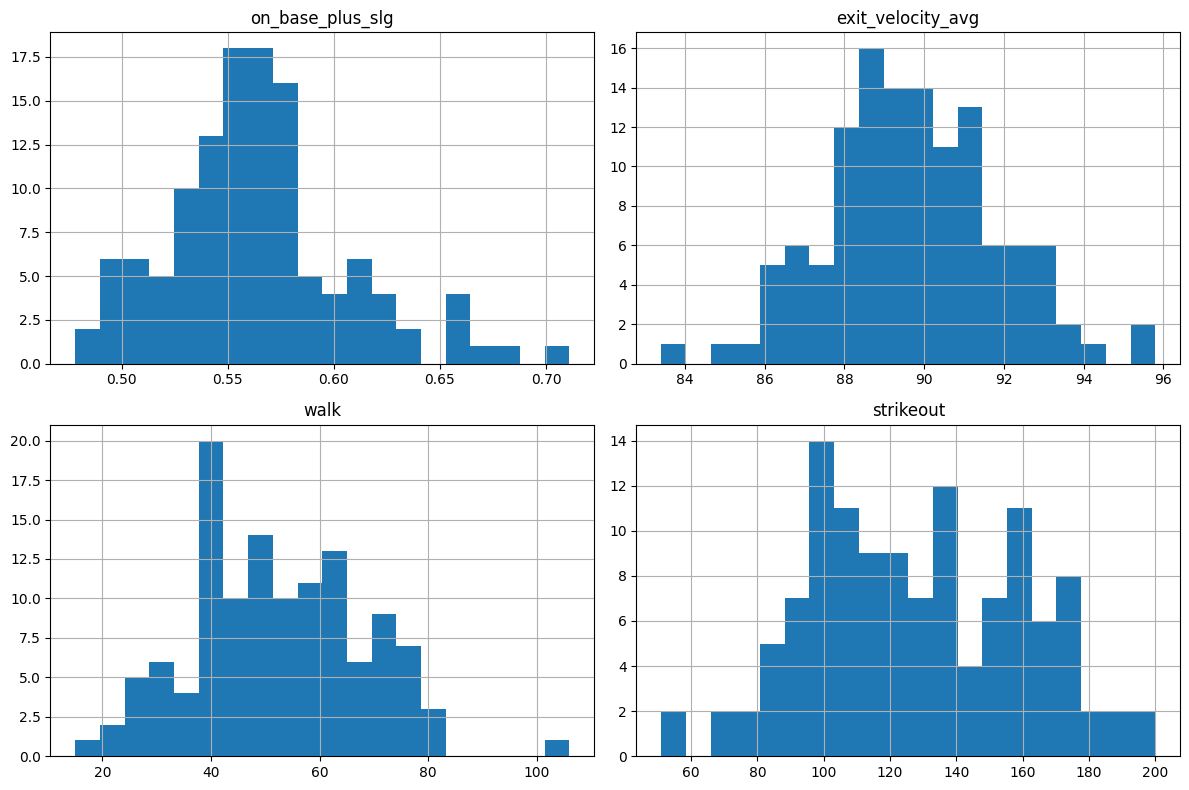

In [45]:
# Plot distributions of key numeric features
features_to_plot = ['on_base_plus_slg', 'exit_velocity_avg', 'walk', 'strikeout']
df_2023_clean[features_to_plot].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()


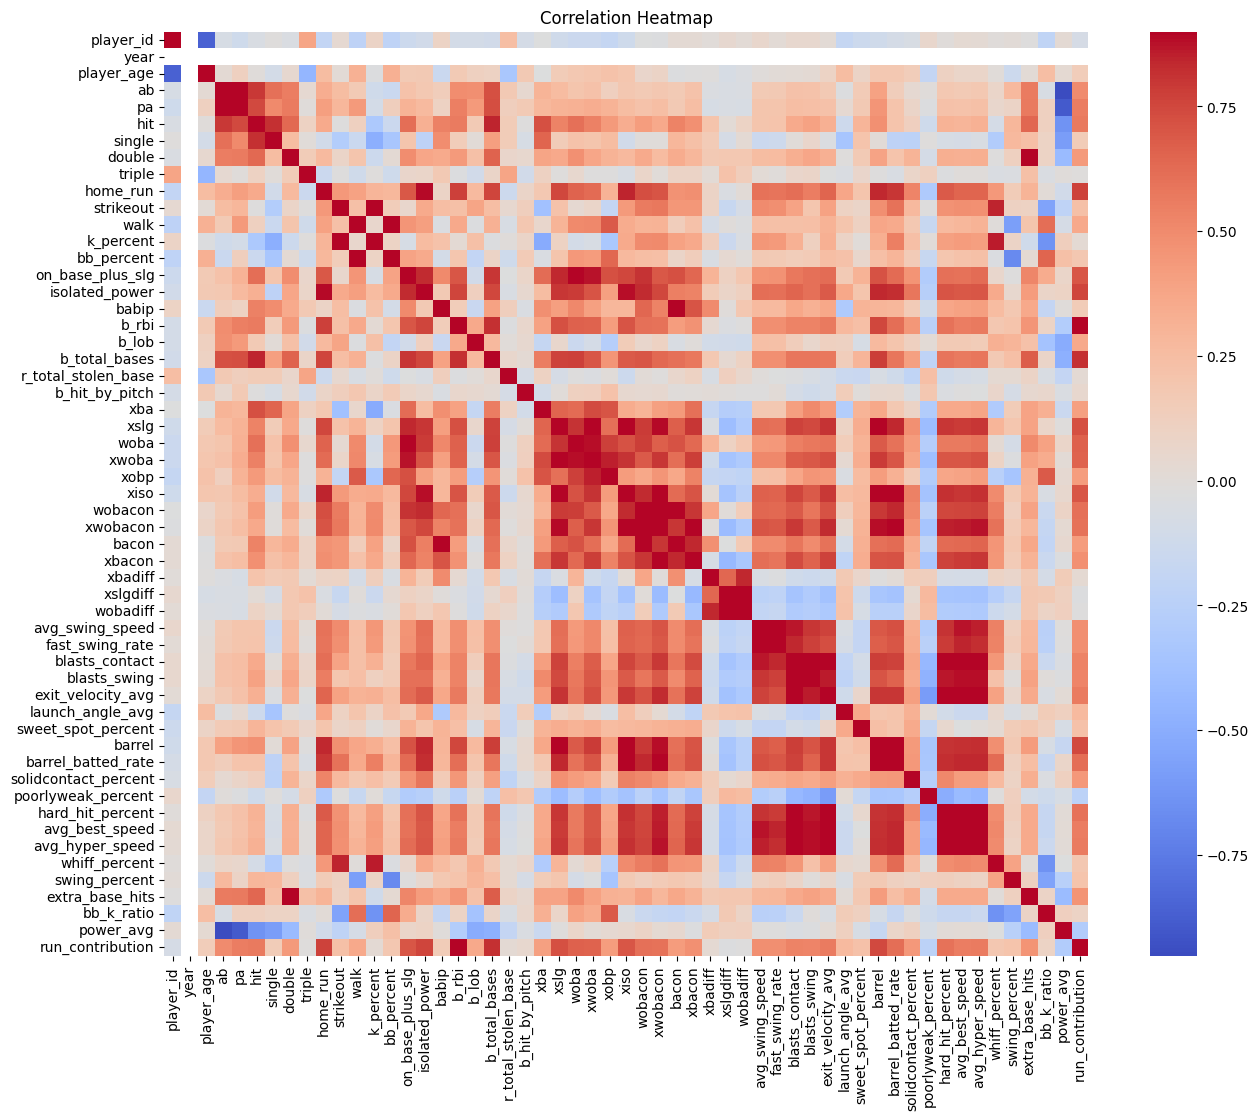

In [46]:
# Correlation matrix
corr = df_2023_clean[numerical_vars].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap="coolwarm", square=True, annot=False, vmax=0.9)
plt.title("Correlation Heatmap")
plt.show()


## Section 3: Predictive Analytics (100 Points)

- Supervised learning (regression)
- Evaluate with R2, RMSE, MAE


In [47]:
# Define target and features
from sklearn.model_selection import train_test_split


target = 'on_base_plus_slg'
features = [
    'hit', 'walk', 'strikeout', 'home_run', 'double', 'triple',
    'b_rbi', 'b_total_bases', 'exit_velocity_avg', 'launch_angle_avg',
    'sweet_spot_percent', 'barrel_batted_rate', 'hard_hit_percent',
    'power_avg', 'bb_k_ratio', 'extra_base_hits', 'run_contribution'
]

X = df_2023_clean[features]
y = df_2023_clean[target]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:
# Model comparison
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error,  root_mean_squared_error
import xgboost


models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=1),
    'XGBoost': xgboost.XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.05),
    'LightGBM': LGBMRegressor(n_estimators=500, max_depth=4, learning_rate=0.05)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, preds),
        "RMSE": root_mean_squared_error(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds)
    }

pd.DataFrame(results).T.sort_values("RMSE")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 17
[LightGBM] [Info] Start training from score 0.563049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,R2,RMSE,MAE
LinearRegression,0.993036,0.003285,0.002335
LightGBM,0.791167,0.017990,0.015753
XGBoost,0.778760,0.018516,0.014497
RandomForest,0.685764,0.022067,0.016469
